In [7]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import json
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA Device:", torch.cuda.get_device_name(0))

PyTorch Version: 2.9.1+cpu
CUDA Available: False


In [8]:
SEED = 42

def set_seed(seed=42):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Random seed set to {seed}")

set_seed(SEED)

Random seed set to 42


In [ ]:
class Config:

    DATA_DIR = r"C:\Users\User\Desktop\springfield_identity\characters_train"
    MODEL_SAVE_PATH = r"C:\Users\User\Desktop\springfield_identity\models\simpsons_cnn.pth"
    
    # hyperparameters
    IMG_SIZE = 128  # resize all images to 128x128
    BATCH_SIZE = 32
    NUM_EPOCHS = 30
    LEARNING_RATE = 0.001
    VALIDATION_SPLIT = 0.2
    
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
config = Config()
print(f"\nConfiguration:")
print(f"  Device: {config.DEVICE}")
print(f"  Image Size: {config.IMG_SIZE}x{config.IMG_SIZE}")
print(f"  Batch Size: {config.BATCH_SIZE}")
print(f"  Epochs: {config.NUM_EPOCHS}")
print(f"  Learning Rate: {config.LEARNING_RATE}")


Configuration:
  Device: cpu
  Image Size: 128x128
  Batch Size: 32
  Epochs: 30
  Learning Rate: 0.001


In [ ]:
class SimpsonsDataset(Dataset):
    
    def __init__(self, data_dir, transform=None):
        """
        Args ->
            data_dir: Path to the characters_train directory
            transform: Optional transforms to apply to images
        """
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = []
        
        # get sorted list of class names (character folders)
        self.class_names = sorted([d for d in os.listdir(data_dir) 
                                   if os.path.isdir(os.path.join(data_dir, d))])
        
        # create class to index mapping
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.class_names)}
        self.idx_to_class = {idx: class_name for class_name, idx in self.class_to_idx.items()}
        
        # load all image paths and labels
        print("Loading dataset...")
        for class_name in self.class_names:
            class_path = os.path.join(data_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            # get all jpg files in this class folder
            image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]
            
            for img_file in image_files:
                img_path = os.path.join(class_path, img_file)
                self.images.append(img_path)
                self.labels.append(class_idx)
        
        print(f"Loaded {len(self.images)} images from {len(self.class_names)} classes")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # load image
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        # apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def get_class_distribution(self):
        """Return distribution of samples per class"""
        class_counts = {}
        for label in self.labels:
            class_name = self.idx_to_class[label]
            class_counts[class_name] = class_counts.get(class_name, 0) + 1
        return class_counts


In [ ]:
# training transforms (with data augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# validation transforms (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

print("Data transforms defined:")
print("  Training: Resize, RandomFlip, Rotation, ColorJitter, Normalize")
print("  Validation: Resize, Normalize")

Data transforms defined:
  Training: Resize, RandomFlip, Rotation, ColorJitter, Normalize
  Validation: Resize, Normalize


In [ ]:
# load dataset without transforms to get indices
full_dataset = SimpsonsDataset(config.DATA_DIR, transform=None)

# get labels for stratified split
all_labels = full_dataset.labels

# create stratified train/val split
train_indices, val_indices = train_test_split(
    range(len(full_dataset)),
    test_size=config.VALIDATION_SPLIT,
    random_state=SEED,
    stratify=all_labels
)

print(f"\nDataset Split:")
print(f"  Training samples: {len(train_indices)}")
print(f"  Validation samples: {len(val_indices)}")
print(f"  Split ratio: {1-config.VALIDATION_SPLIT:.0%} / {config.VALIDATION_SPLIT:.0%}")


Loading dataset...
Loaded 16764 images from 42 classes

Dataset Split:
  Training samples: 13411
  Validation samples: 3353
  Split ratio: 80% / 20%


In [ ]:
class SubsetDataset(Dataset):
    """Wrapper to apply transforms to a subset of indices"""
    def __init__(self, base_dataset, indices, transform):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        img_path = self.base_dataset.images[actual_idx]
        label = self.base_dataset.labels[actual_idx]
        
        # load image
        image = Image.open(img_path).convert('RGB')
        
        # apply transform
        if self.transform:
            image = self.transform(image)
        
        return image, label

# create train and validation datasets with appropriate transforms
train_dataset = SubsetDataset(full_dataset, train_indices, train_transforms)
val_dataset = SubsetDataset(full_dataset, val_indices, val_transforms)

# create data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=config.BATCH_SIZE, 
    shuffle=True,
    num_workers=0,  # set to 0 for Windows compatibility
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=config.BATCH_SIZE, 
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print(f"\nData Loaders Created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Number of classes: {len(full_dataset.class_names)}")


Data Loaders Created:
  Train batches: 420
  Val batches: 105
  Number of classes: 42


In [ ]:
class SimpsonsCNN(nn.Module):
    """Custom CNN for Simpsons character classification"""
    
    def __init__(self, num_classes=42):
        super(SimpsonsCNN, self).__init__()
        
        # convolutional block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        
        # convolutional block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        
        # convolutional block 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        
        # convolutional block 4
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        
        # fully connected layers
        # after 4 max pooling operations: 128 -> 64 -> 32 -> 16 -> 8
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.fc(x)
        return x

In [ ]:
# initialize model
model = SimpsonsCNN(num_classes=len(full_dataset.class_names))
model = model.to(config.DEVICE)

# count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\nModel Architecture:")
print(model)
print(f"\nTotal Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")


Model Architecture:
SimpsonsCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel

In [ ]:
# Loss Function, Optimizer, and Scheduler
# calculate class weights for imbalanced dataset
class_distribution = full_dataset.get_class_distribution()
class_counts = [class_distribution[full_dataset.idx_to_class[i]] for i in range(len(full_dataset.class_names))]
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
class_weights = class_weights / class_weights.sum() * len(class_weights)  # normalize
class_weights = class_weights.to(config.DEVICE)

print("\nTraining Setup:")
print(f"  Using class weights: Yes (for imbalanced dataset)")
print(f"  Min class weight: {class_weights.min().item():.4f}")
print(f"  Max class weight: {class_weights.max().item():.4f}")

# loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

# learning rate scheduler (reduce LR on plateau)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=3
)

print(f"  Loss Function: CrossEntropyLoss with class weights")
print(f"  Optimizer: Adam (lr={config.LEARNING_RATE})")
print(f"  Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")


Training Setup:
  Using class weights: Yes (for imbalanced dataset)
  Min class weight: 0.0208
  Max class weight: 12.4493
  Loss Function: CrossEntropyLoss with class weights
  Optimizer: Adam (lr=0.001)
  Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)


In [ ]:
# training and validation functions
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc='Training')
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        
        # forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward pass
        loss.backward()
        optimizer.step()
        
        # statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc='Validation')
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            
            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # store predictions for F1 calculation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # update progress bar
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    
    return epoch_loss, epoch_acc, macro_f1



Training and validation functions defined.


In [ ]:
print("STARTING TRAINING")

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': []
}

best_val_loss = float('inf')
best_epoch = 0

for epoch in range(config.NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{config.NUM_EPOCHS}")
    print("-" * 70)
    
    # train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, config.DEVICE)
    
    # validate
    val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, criterion, config.DEVICE)
    
    # update scheduler
    scheduler.step(val_loss)
    
    # S\save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"  Val Macro F1: {val_f1:.4f}")
    
    # save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_f1': val_f1,
            'class_names': full_dataset.class_names,
            'class_to_idx': full_dataset.class_to_idx,
            'idx_to_class': full_dataset.idx_to_class
        }, config.MODEL_SAVE_PATH)
        print(f"  Best model saved! (Val Loss: {val_loss:.4f})")

print("TRAINING COMPLETE")
print(f"Best model from epoch {best_epoch} with validation loss: {best_val_loss:.4f}")
print(f"Model saved to: {config.MODEL_SAVE_PATH}")

STARTING TRAINING

Epoch 1/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [01:30<00:00,  1.15it/s, loss=3.7316, acc=9.90%]



Epoch 1 Summary:
  Train Loss: 3.8875 | Train Acc: 4.51%
  Val Loss:   3.4861 | Val Acc:   9.90%
  Val Macro F1: 0.0430
  ✓ Best model saved! (Val Loss: 3.4861)

Epoch 2/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [00:56<00:00,  1.86it/s, loss=4.0167, acc=11.12%]



Epoch 2 Summary:
  Train Loss: 3.5676 | Train Acc: 7.81%
  Val Loss:   3.3539 | Val Acc:   11.12%
  Val Macro F1: 0.0615
  ✓ Best model saved! (Val Loss: 3.3539)

Epoch 3/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [00:57<00:00,  1.84it/s, loss=4.1596, acc=14.91%]



Epoch 3 Summary:
  Train Loss: 3.4145 | Train Acc: 10.23%
  Val Loss:   3.2749 | Val Acc:   14.91%
  Val Macro F1: 0.0994
  ✓ Best model saved! (Val Loss: 3.2749)

Epoch 4/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [01:25<00:00,  1.23it/s, loss=4.3493, acc=17.00%]



Epoch 4 Summary:
  Train Loss: 3.2402 | Train Acc: 13.11%
  Val Loss:   3.1012 | Val Acc:   17.00%
  Val Macro F1: 0.1043
  ✓ Best model saved! (Val Loss: 3.1012)

Epoch 5/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [00:54<00:00,  1.93it/s, loss=4.4143, acc=21.03%]



Epoch 5 Summary:
  Train Loss: 3.1086 | Train Acc: 16.23%
  Val Loss:   3.0068 | Val Acc:   21.03%
  Val Macro F1: 0.1307
  ✓ Best model saved! (Val Loss: 3.0068)

Epoch 6/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [00:53<00:00,  1.95it/s, loss=3.9215, acc=21.89%]



Epoch 6 Summary:
  Train Loss: 2.9509 | Train Acc: 19.10%
  Val Loss:   2.8160 | Val Acc:   21.89%
  Val Macro F1: 0.1390
  ✓ Best model saved! (Val Loss: 2.8160)

Epoch 7/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [00:56<00:00,  1.87it/s, loss=4.4463, acc=26.25%]



Epoch 7 Summary:
  Train Loss: 2.8397 | Train Acc: 21.74%
  Val Loss:   2.6734 | Val Acc:   26.25%
  Val Macro F1: 0.1929
  ✓ Best model saved! (Val Loss: 2.6734)

Epoch 8/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [00:56<00:00,  1.87it/s, loss=3.9567, acc=30.09%]



Epoch 8 Summary:
  Train Loss: 2.6994 | Train Acc: 23.61%
  Val Loss:   2.4471 | Val Acc:   30.09%
  Val Macro F1: 0.2135
  ✓ Best model saved! (Val Loss: 2.4471)

Epoch 9/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [00:52<00:00,  2.01it/s, loss=4.1926, acc=33.76%]



Epoch 9 Summary:
  Train Loss: 2.5847 | Train Acc: 25.90%
  Val Loss:   2.3840 | Val Acc:   33.76%
  Val Macro F1: 0.2292
  ✓ Best model saved! (Val Loss: 2.3840)

Epoch 10/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [00:52<00:00,  2.01it/s, loss=3.6924, acc=35.94%]



Epoch 10 Summary:
  Train Loss: 2.4848 | Train Acc: 28.16%
  Val Loss:   2.2609 | Val Acc:   35.94%
  Val Macro F1: 0.2709
  ✓ Best model saved! (Val Loss: 2.2609)

Epoch 11/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [00:46<00:00,  2.24it/s, loss=3.5235, acc=39.55%]



Epoch 11 Summary:
  Train Loss: 2.3714 | Train Acc: 30.17%
  Val Loss:   2.1211 | Val Acc:   39.55%
  Val Macro F1: 0.2940
  ✓ Best model saved! (Val Loss: 2.1211)

Epoch 12/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [05:28<00:00,  3.13s/it, loss=4.4279, acc=41.04%] 



Epoch 12 Summary:
  Train Loss: 2.3174 | Train Acc: 31.76%
  Val Loss:   2.0756 | Val Acc:   41.04%
  Val Macro F1: 0.2967
  ✓ Best model saved! (Val Loss: 2.0756)

Epoch 13/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [00:51<00:00,  2.03it/s, loss=3.3235, acc=41.63%]



Epoch 13 Summary:
  Train Loss: 2.1415 | Train Acc: 33.99%
  Val Loss:   1.9635 | Val Acc:   41.63%
  Val Macro F1: 0.3338
  ✓ Best model saved! (Val Loss: 1.9635)

Epoch 14/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [01:01<00:00,  1.71it/s, loss=4.4576, acc=39.87%]



Epoch 14 Summary:
  Train Loss: 2.0336 | Train Acc: 35.69%
  Val Loss:   1.9750 | Val Acc:   39.87%
  Val Macro F1: 0.3126

Epoch 15/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [00:48<00:00,  2.17it/s, loss=4.0523, acc=45.30%]



Epoch 15 Summary:
  Train Loss: 1.9930 | Train Acc: 36.16%
  Val Loss:   1.8364 | Val Acc:   45.30%
  Val Macro F1: 0.3268
  ✓ Best model saved! (Val Loss: 1.8364)

Epoch 16/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [01:28<00:00,  1.18it/s, loss=3.6405, acc=48.55%]



Epoch 16 Summary:
  Train Loss: 1.9121 | Train Acc: 38.87%
  Val Loss:   1.7365 | Val Acc:   48.55%
  Val Macro F1: 0.3712
  ✓ Best model saved! (Val Loss: 1.7365)

Epoch 17/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [00:50<00:00,  2.06it/s, loss=2.9142, acc=50.19%]



Epoch 17 Summary:
  Train Loss: 1.7689 | Train Acc: 41.63%
  Val Loss:   1.6412 | Val Acc:   50.19%
  Val Macro F1: 0.3934
  ✓ Best model saved! (Val Loss: 1.6412)

Epoch 18/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [00:51<00:00,  2.04it/s, loss=6.0158, acc=47.81%]



Epoch 18 Summary:
  Train Loss: 1.7005 | Train Acc: 42.80%
  Val Loss:   1.7310 | Val Acc:   47.81%
  Val Macro F1: 0.3909

Epoch 19/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [01:21<00:00,  1.28it/s, loss=4.0305, acc=51.98%]



Epoch 19 Summary:
  Train Loss: 1.6630 | Train Acc: 44.27%
  Val Loss:   1.5686 | Val Acc:   51.98%
  Val Macro F1: 0.4434
  ✓ Best model saved! (Val Loss: 1.5686)

Epoch 20/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [01:41<00:00,  1.03it/s, loss=5.3060, acc=53.44%]



Epoch 20 Summary:
  Train Loss: 1.6009 | Train Acc: 45.62%
  Val Loss:   1.6341 | Val Acc:   53.44%
  Val Macro F1: 0.4278

Epoch 21/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [01:18<00:00,  1.34it/s, loss=2.8548, acc=54.82%]



Epoch 21 Summary:
  Train Loss: 1.5213 | Train Acc: 47.48%
  Val Loss:   1.5209 | Val Acc:   54.82%
  Val Macro F1: 0.4329
  ✓ Best model saved! (Val Loss: 1.5209)

Epoch 22/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [02:18<00:00,  1.32s/it, loss=4.2477, acc=56.25%]



Epoch 22 Summary:
  Train Loss: 1.4632 | Train Acc: 49.24%
  Val Loss:   1.3972 | Val Acc:   56.25%
  Val Macro F1: 0.4678
  ✓ Best model saved! (Val Loss: 1.3972)

Epoch 23/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [01:05<00:00,  1.60it/s, loss=1.4984, acc=60.42%]



Epoch 23 Summary:
  Train Loss: 1.4218 | Train Acc: 48.62%
  Val Loss:   1.3440 | Val Acc:   60.42%
  Val Macro F1: 0.4928
  ✓ Best model saved! (Val Loss: 1.3440)

Epoch 24/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [00:45<00:00,  2.29it/s, loss=2.9387, acc=59.53%]



Epoch 24 Summary:
  Train Loss: 1.3504 | Train Acc: 50.86%
  Val Loss:   1.3330 | Val Acc:   59.53%
  Val Macro F1: 0.4779
  ✓ Best model saved! (Val Loss: 1.3330)

Epoch 25/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [00:52<00:00,  2.01it/s, loss=1.1413, acc=58.75%]



Epoch 25 Summary:
  Train Loss: 1.2839 | Train Acc: 52.25%
  Val Loss:   1.2931 | Val Acc:   58.75%
  Val Macro F1: 0.4812
  ✓ Best model saved! (Val Loss: 1.2931)

Epoch 26/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [00:45<00:00,  2.32it/s, loss=3.7218, acc=61.80%]



Epoch 26 Summary:
  Train Loss: 1.2708 | Train Acc: 52.32%
  Val Loss:   1.2635 | Val Acc:   61.80%
  Val Macro F1: 0.5076
  ✓ Best model saved! (Val Loss: 1.2635)

Epoch 27/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [00:54<00:00,  1.93it/s, loss=0.6482, acc=60.42%]



Epoch 27 Summary:
  Train Loss: 1.1888 | Train Acc: 54.38%
  Val Loss:   1.2997 | Val Acc:   60.42%
  Val Macro F1: 0.4832

Epoch 28/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [01:00<00:00,  1.75it/s, loss=0.5433, acc=64.18%]



Epoch 28 Summary:
  Train Loss: 1.1321 | Train Acc: 55.79%
  Val Loss:   1.1642 | Val Acc:   64.18%
  Val Macro F1: 0.5449
  ✓ Best model saved! (Val Loss: 1.1642)

Epoch 29/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [00:47<00:00,  2.23it/s, loss=0.5624, acc=63.58%]



Epoch 29 Summary:
  Train Loss: 1.1193 | Train Acc: 57.36%
  Val Loss:   1.1851 | Val Acc:   63.58%
  Val Macro F1: 0.5308

Epoch 30/30
----------------------------------------------------------------------


Validation: 100%|██████████| 105/105 [00:46<00:00,  2.27it/s, loss=0.4523, acc=65.88%]



Epoch 30 Summary:
  Train Loss: 1.0788 | Train Acc: 58.62%
  Val Loss:   1.1028 | Val Acc:   65.88%
  Val Macro F1: 0.5311
  ✓ Best model saved! (Val Loss: 1.1028)

TRAINING COMPLETE
Best model from epoch 30 with validation loss: 1.1028
Model saved to: C:\Users\User\Desktop\springfield_identity\models\simpsons_cnn.pth


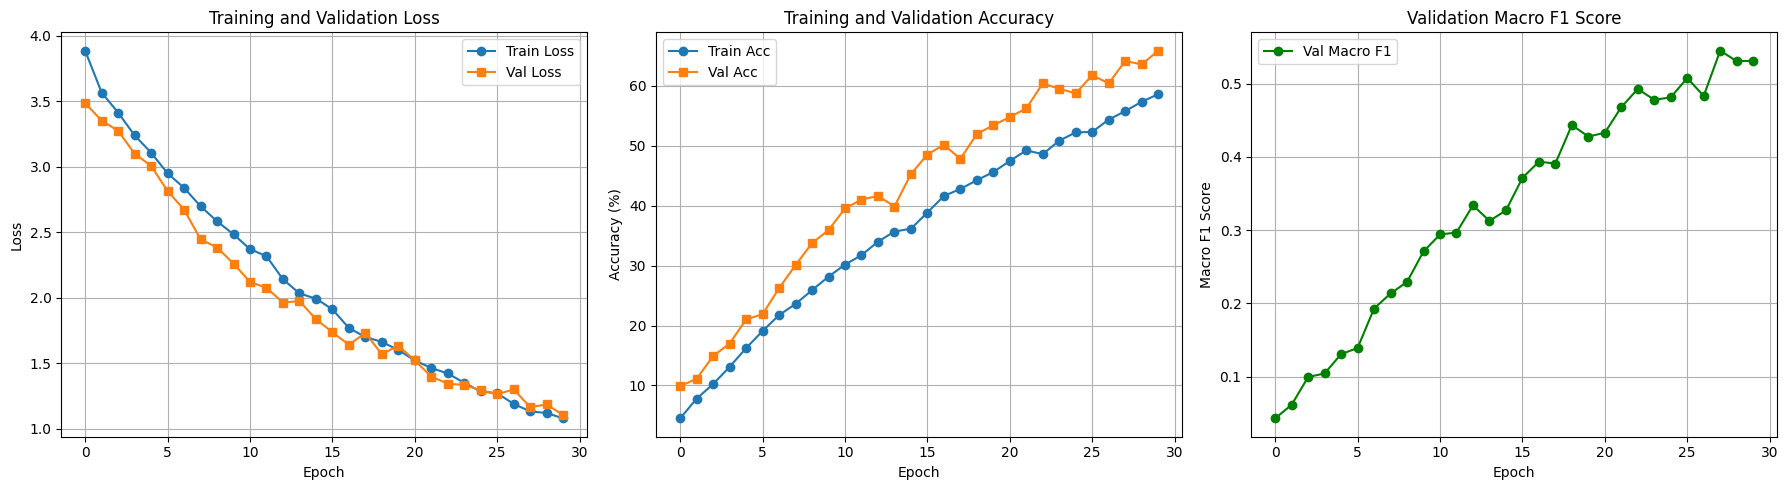

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(history['val_f1'], label='Val Macro F1', marker='o', color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Macro F1 Score')
axes[2].set_title('Validation Macro F1 Score')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig(r'training_history.png', dpi=150, bbox_inches='tight')
plt.show()
